# Modeling a 3-phase inverter in the dq reference frame

Abstract 

> A bit of symbolic math and several hand written equations to go from the circuit equations expressed in the natural *abc* reference frame to the synchronously rotating *dq* reference frame.

Pierre Haessig —  May 2015

In [1]:
import sympy
from sympy import symbols, simplify, Matrix, sqrt, Rational
from sympy import pi, cos, sin, exp

In [2]:
sympy.init_printing()

## 1) Prelude: coordinate transformations

### 1a) *αβ* (Clarke) transform

it reduces the 3-phased variables (voltages or currents) into two coordinates in a fixed orthogonal reference frame:
$$ v_{\alpha \beta }(t)=
   \frac 23
   \begin{bmatrix}
       1&-{\frac 12}&-{\frac 12}\\
       0& {\frac {{\sqrt {3}}}{2}}&-{\frac {{\sqrt {3}}}{2}}
   \end{bmatrix}
   \begin{bmatrix}
       i_{a}(t)\\i_{b}(t)\\i_{c}(t)
   \end{bmatrix}
$$

axis $\alpha$ is aligned with axis a, and $\beta$ is orthogonal, toward b

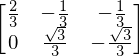

In [5]:
half = Rational(1,2)
T = Rational(2,3) * Matrix(
    [[1, -half, -half],
     [0, sqrt(3)*half, -sqrt(3)*half]])
T

### 1b) *dq* (Park) transform

$$ v_{dq}(t)=
   \begin{bmatrix}
        \cos \theta(t)& \sin \theta(t)\\
       -\sin\theta(t)& \cos \theta(t)
   \end{bmatrix}
   v_{\alpha \beta }(t)
$$

→ $T_{dq}(\theta(t))$ matrix (a rotation matrix by angle $\theta$)

with angle $\theta(t)$ being generally rotating at a fixed speed $\omega t + \theta_{ref}$

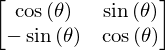

In [8]:
th = symbols('theta')
Tdq = Matrix(
    [[ cos(th), sin(th)],
     [-sin(th), cos(th)]])

Tdq

synchronization with the grid

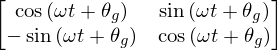

In [24]:
t, thg = symbols('t theta_g')
w = symbols('omega', nonzero=True)
Tdq_g = Tdq.subs(th, w*t+thg)
Tdq_g

Note: there are some disagreements about sign convention and normalization for these transorms.

### 1c) Verification of the transformation interest

With the Park transorm, a three-phased sinusoidal variables become constant ("DC") variables.

Example with the converter voltages:

In [25]:
Vc, thc = symbols('V_c theta_c')

vc_a = Vc*cos(w*t+thc)
vc_b = Vc*cos(w*t+thc-2*pi/3)
vc_c = Vc*cos(w*t+thc-4*pi/3)

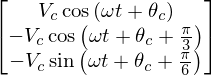

In [26]:
vc_abc = Matrix([vc_a, vc_b, vc_c])
vc_abc

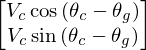

In [27]:
vc_dq = simplify(Tdq_g * T * vc_abc)
vc_dq

Conclusion: we indeed get a constant vector (as long as the amplitude and the phase are constants...)

## 2) Inverter dynamics modeling

### 2a) Starting point: equations in the natural *abc* frame

for each phase, named *a,b*, and *c*, we have:

$$L \frac{di_a}{dt} = vc_a - vg_a$$

so globally we have three equations:

$$ L \frac{di_{abc}}{dt} = vc_{abc} - vg_{abc} $$

(although only 2 out of 3 inductor currents are independant, because of the current's law $i_a+i_b+i_c = 0$).

### 2b) αβ equations

Multiplying by $T_{\alpha \beta}$, we get two equations:

$$ L \frac{di_{\alpha \beta}}{dt} = vc_{\alpha \beta} - vg_{\alpha \beta} $$

These are completely independant. However, variables are still sinusoidals.

### 2c) dq equations

We use the inverse (dq→αβ) transorm. It is:

$$x_{\alpha \beta} = T_{dq}^T(t) x_{dq},$$

because $T_{dq}$ is a orthogonal matrix: (property $Q^{-1} = Q^T$).

Replacing all αβ vectors in the electrical equation we get:

$$ L \frac{d ( T_{dq}^T(t) i_{dq} )}{dt} = T_{dq}^T(t)vc_{dq} - T_{dq}^T(t)vg_{dq} $$

and this include a product of two functions to derive:

$$\frac{d ( T_{dq}^T(t) i_{dq} )}{dt} = 
    T_{dq}^T(t) \frac{di_{dq}}{dt} + 
    \frac{dT_{dq}^T(t)}{dt}i_{dq}
    $$

the derivative of the dq matrix has a special property:

$$\frac{dT_{dq}(t)}{dt} = \frac{dT_{dq}(\theta)}{d\theta} \dot{\theta}$$


($\dot{\theta} = \omega$ the grid frequency (in rad/s), assumed to be constant, or at least slowly varying)

The derivative of the $T_{dq}(\theta)$ matrix yields axes rotated by $+\pi/2$:

$$ \frac{dT_{dq}(\theta)}{d\theta} =
    \begin{bmatrix}
     0& 1\\
    -1& 0
    \end{bmatrix}
    T_{dq}(\theta)$$

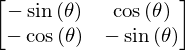

In [42]:
Tdq.diff(th)

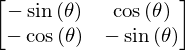

In [44]:
R90 = Matrix([[0, 1],
              [-1, 0]])
R90*Tdq

So the $\frac{dT_{dq}^T(t)}{dt}i_{dq}$ term becomes (noting that rot(90) transposed is rot(-90))

$$ \omega T_{dq}^T 
   \begin{bmatrix}
     0& -1\\
     1& 0
    \end{bmatrix}$$

####  Final dq equation

in the end, multiplying by $T_{dq}$ simplifies the $T_{dq}^T$ terms (again: orthogonal matrix)

$$ L \frac{di_{dq}}{dt} = vc_{dq} - vg_{dq} +
    \begin{bmatrix}
     0& L\omega\\
     -L\omega& 0
    \end{bmatrix}
    i_{dq}
    $$

#### Current cross coupling
Observation: there is a cross coupling term between the d-axis current and the q-axis current. They dynamically influence each other.

Explanation: in absence of voltage ($vc = vg =0$), we are left only with ideal inductors. Their currents keep constant in the natural *abc* frame. These constant (DC) currents correspond to a rotation at $-\omega$ speed in the *dq* frame.

## 3) Inverter control structure

### 3a) Feedforward terms:

we simplify the dynamics by including two feedforward terms:

$$ vc_{dq} = vg_{dq} +
    \begin{bmatrix}
     0& -L\omega\\
     +L\omega& 0
    \end{bmatrix}
    i_{dq} + u_{dq}
$$


#### About grid voltage feedforward

It makes sense because the converter voltages should be equal to the grid voltages in order to have zero current (especially usefull at startup).

Thanks to these two feedforward terms, the dynamics reduces to two independant integrators: the d and q channels can be **controlled independantly**.

$$ L \frac{di_{dq}}{dt} = u_{dq} $$

### 3b) Controller design

Because the open-loop system is an integrator, a simple proportional controller ($C(s) = K_p$) could be enough.
However, if we take into account some parasitic *series resistance*, the open loop system becomes a first order R-L system.
Therefore, we choose a PI controller to eliminate any static error: 

$$C(s) = K_p(1 + \frac{1}{T_i s})$$

See the [PI control design](PI_control.ipynb) notebook for how to tune the controller